# Identifying Plumes from AOD and Fire Location

IMPORTANT: Run the function cell located at the bottom of the workbook before running any other cell 

Fires are often associatied with a plume, which will have likely have higher optical depth than the surrounding background and likely spatially connected to a fire cluster.  For a given fire cluster, if we can identify the background level of AOD (and its variance), we can apply this as a threshold to discrimiate plumes through a flood filling approach progressing from the highest AOD pixel associated with the fire cluster including all those pixels above the background.  

Undesirable plumes, with multiple sources for example, can be excluded through postprocessing.

In [1]:
import os
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import scipy.signal
from skimage.measure import label, regionprops
from sklearn.cluster import DBSCAN
from sklearn.neighbors import BallTree
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pyresample as pr
import pyproj

import sys
sys.path.append("../")
import src.data.tools as tools

In [2]:
# Load in AOD and GEO data for test file:
viirs_path = '/Volumes/INTENSO/kcl-ltss-bioatm/raw/viirs'
aod_fname = 'aod/IVAOT_npp_d20160731_t1712526_e1714168_b24662_c20181017161805657097_noaa_ops.h5'
geo_fname = 'geo/GMTCO_npp_d20160731_t1712526_e1714168_b24662_c20181019184400830846_noaa_ops.h5'
aod_h5 = h5py.File(os.path.join(viirs_path, aod_fname), "r")
geo_h5 = h5py.File(os.path.join(viirs_path, geo_fname), "r")

In [3]:
fire_path = '/Volumes/INTENSO/kcl-ltss-bioatm/raw/fires'
fire_csv = 'fire_archive_V1_24485.csv'
fire_df = pd.read_csv(os.path.join(fire_path, fire_csv))
fire_df['date_time'] = pd.to_datetime(fire_df['acq_date'])

In [6]:
aod = aod_h5['All_Data']['VIIRS-Aeros-Opt-Thick-IP_All']['faot550'][:]
aod_qual = aod_h5['All_Data']['VIIRS-Aeros-Opt-Thick-IP_All']['QF1'][:]
lat = geo_h5['All_Data']['VIIRS-MOD-GEO-TC_All']['Latitude'][:]
lon = geo_h5['All_Data']['VIIRS-MOD-GEO-TC_All']['Longitude'][:]

flag = np.zeros(aod_qual.shape)
for k, v in zip(['00', '01', '10', '11'], [0, 1, 2, 3]):
    mask = read_aod_mask(aod_qual, 0, 2, k)
    flag[mask] = v

Plot AOD and select roi

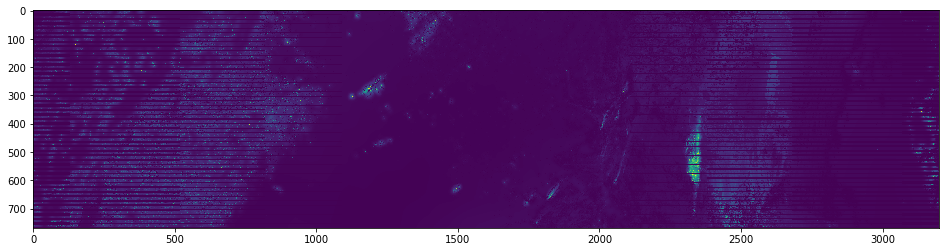

In [7]:
fig = plt.figure(figsize=(20,4))
plt.imshow(aod, vmin=0)
plt.show()

In [8]:
class utm_resampler(object):
    def __init__(self, lats, lons, pixel_size):
        self.lats = lats
        self.lons = lons
        self.pixel_size = pixel_size
        self.zone = self.__utm_zone()
        self.proj = self.__utm_proj()
        self.extent = self.__get_extent()
        self.x_size, self.y_size = self.__utm_grid_size()
        self.area_def = self.__construct_area_def_utm()

    def __utm_zone(self):
        '''
        Some of the plumes will cross UTM zones.  This is not problematic
        as the plumes are quite small and so, we can just use the zone
        in which most of the data falls: https://goo.gl/3QY2Re
        see also: http://www.igorexchange.com/node/927 for if we need over Svalbard (highly unlikely)
        '''
        lons = (self.lons + 180) - np.floor((self.lons + 180) / 360) * 360 - 180
        return stats.mode(np.floor((lons + 180) / 6) + 1, axis=None)[0][0]

    def __utm_proj(self):
        return pyproj.Proj(proj='utm', zone=self.zone, ellps='WGS84', datum='WGS84')
    
    def __get_extent(self):
        x, y = self.proj(self.lons, self.lats)
        min_x, max_x = np.min(x), np.max(x)
        min_y, max_y = np.min(y), np.max(y)
        return (min_x, min_y, max_x, max_y) 
    
    def __utm_grid_size(self):
        x_size = int(np.round((self.extent[2] - self.extent[0]) / self.pixel_size))
        y_size = int(np.round((self.extent[3] - self.extent[1]) / self.pixel_size))
        return x_size, y_size

    def __construct_area_def_utm(self):
        area_id = 'utm'
        description = 'utm_grid'
        proj_id = 'utm'
        proj_dict = {'units': 'm', 'proj': 'utm', 'zone': str(self.zone), 'ellps': 'WGS84', 'datum': 'WGS84'}
        return pr.geometry.AreaDefinition(area_id, description, proj_id, proj_dict,
                                          self.x_size, self.y_size, self.extent)
    

    def resample_image(self, image, image_lats, image_lons, fill_value=-999):
        swath_def = pr.geometry.SwathDefinition(lons=image_lons, lats=image_lats)
        return pr.kd_tree.resample_nearest(swath_def,
                                           image,
                                           self.area_def,
                                           radius_of_influence=3000,
                                           fill_value=fill_value)

    def resample_points_to_utm(self, point_lats, point_lons):
        return [self.proj(lon, lat) for lon, lat in zip(point_lons, point_lats)]

    def resample_point_to_geo(self, point_y, point_x):
        return self.proj(point_x, point_y, inverse=True)

In [9]:
# resample AOD to UTM
utm_resample = utm_resampler(lat, lon, 750)
fv = np.nan

mask = aod < 0
masked_lats = np.ma.masked_array(utm_resample.lats, mask)
masked_lons = np.ma.masked_array(utm_resample.lons, mask)

lonlats = utm_resample.area_def.get_lonlats()
lat_grid = lonlats[1]
lon_grid = lonlats[0]
aod_r = utm_resample.resample_image(aod, masked_lats, masked_lons, fill_value=fv)
flag_r = utm_resample.resample_image(flag, masked_lats, masked_lons, fill_value=fv)

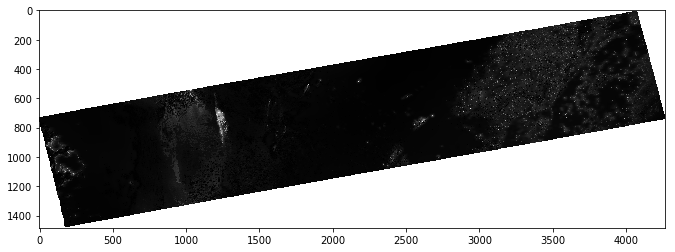

In [10]:
fig = plt.figure(figsize=(20,7))
plt.imshow(aod_r, cmap='gray')
plt.show()

### Subset the fires to the scene

In [11]:
extent = {'min_lat': np.min(lat_grid),
          'max_lat': np.max(lat_grid),
          'min_lon': np.min(lon_grid),
          'max_lon': np.max(lat_grid)}
date_to_find = pd.Timestamp(2016, 7, 31)
image_fires_df = extract_fires_for_roi(fire_df, date_to_find, extent)
image_fires_df = image_fires_df.loc[image_fires_df.frp > 10]

/Users/danielfisher/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [12]:
# cluster fires
coords = image_fires_df[['latitude', 'longitude']].values
dist_in_km = 10
db = DBSCAN(eps=dist_in_km/6371., min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
image_fires_df['cluster_id'] = db.labels_

In [13]:
mean_fire_positions = image_fires_df.groupby('cluster_id').agg({'latitude':np.mean, 'longitude': np.mean})

In [14]:
mean_fire_positions.shape

(273, 2)

## Display AOD and fires

In [18]:
geo_mask = lat_grid != np.nan
balltree = make_balltree_subset(lat_grid[geo_mask], lon_grid[geo_mask])

In [19]:
rows = np.arange(lat_grid.shape[0])
cols = np.arange(lat_grid.shape[1])
cols, rows = np.meshgrid(cols, rows)
cols = cols[geo_mask]
rows = rows[geo_mask]

In [37]:
x_fire_coords, y_fire_coords, d = spatial_intersection_subset(balltree,
                                      mean_fire_positions.latitude.values,
                                      mean_fire_positions.longitude.values,
                                      cols, rows)

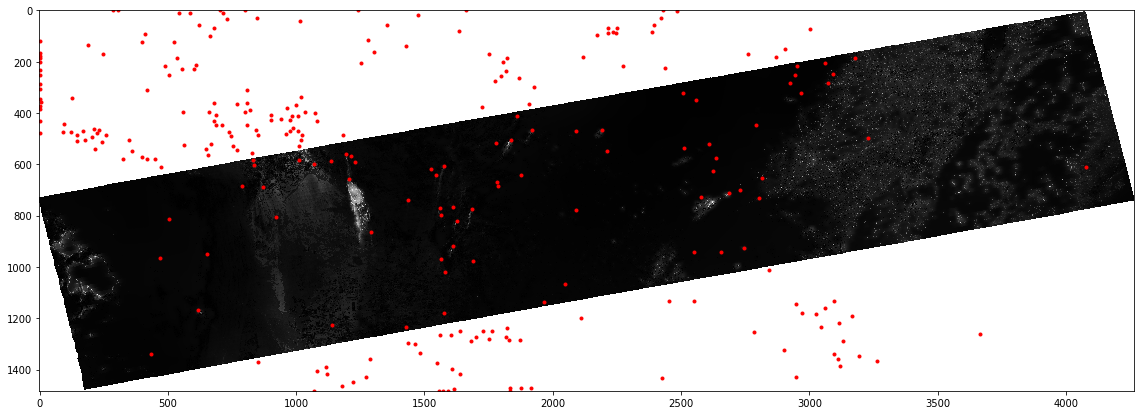

In [38]:
plt.figure(figsize=(20,7))
plt.imshow(aod_r, cmap='gray')
plt.plot(x_fire_coords,y_fire_coords, 'r.')
plt.show()

In [39]:
win_size = 10

new_x = []
new_y = []
max_values = []

for y,x in zip(y_fire_coords, x_fire_coords):
    
    y = y[0]
    x = x[0]
    
    # get bb and aod
    min_y = y-win_size if y-win_size > 0 else 0 
    max_y = y+win_size+1 if y+win_size+1 < aod_r.shape[0] else aod_r.shape[0]
    min_x = x-win_size if x-win_size > 0 else 0
    max_x = x+win_size+1 if x+win_size+1 < aod_r.shape[1] else aod_r.shape[1]
    aod_for_window = aod_r[min_y:max_y, min_x:max_x]
    flg_for_window = flag_r[min_y:max_y, min_x:max_x]
    
    # keep only windows not on the edge
    if aod_for_window.size != (win_size*2+1)**2:
        continue    
    
    # find background window
    sub_window_means = [] 
    sub_window_sd = []
    step_size = int((win_size*2+1) / 3)
    for i in [0, step_size, step_size*2]:
        for j in [0, step_size, step_size*2]:
            sub_window_aod = aod_for_window[i:i+step_size, j:j+step_size]
            sub_window_flag = flg_for_window[i:i+step_size, j:j+step_size]
            sub_window_means.append(np.mean(sub_window_aod))
    
    min_mean = np.min(sub_window_means)
    max_mean = np.max(sub_window_means)
    
    # The ratio allows us to eliminate fires under smoke clouds, or without clear backgrounds, as
    # the smoke signal needs to be at least a factor of three higher than background.  If all the 
    # background is not clear then it will not be located.
    if max_mean / min_mean > 3:
        new_x.append(x)
        new_y.append(y)
        max_values.append(max_mean)


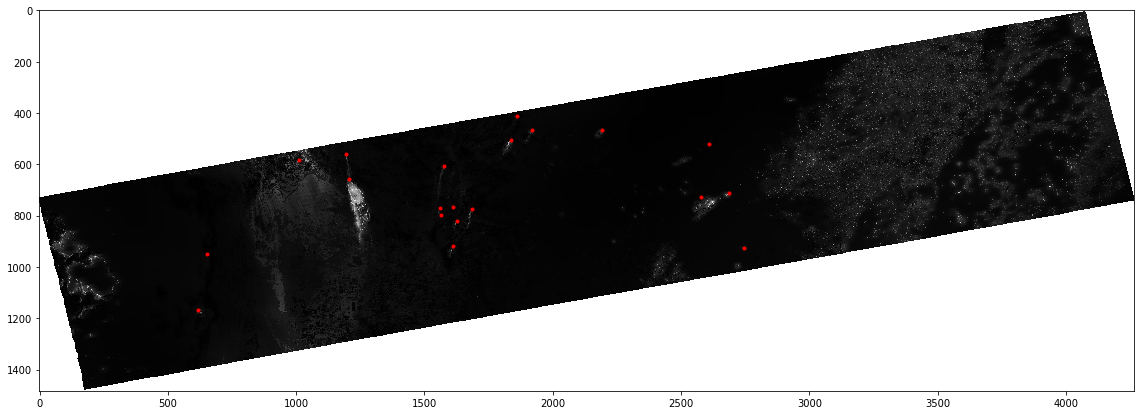

20


In [40]:
plt.figure(figsize=(20,7))
plt.imshow(aod_r, cmap='gray')
plt.plot(new_x,new_y, 'r.')
plt.show()
print(len(new_x))

/Users/danielfisher/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less_equal
  This is separate from the ipykernel package so we can avoid doing imports until


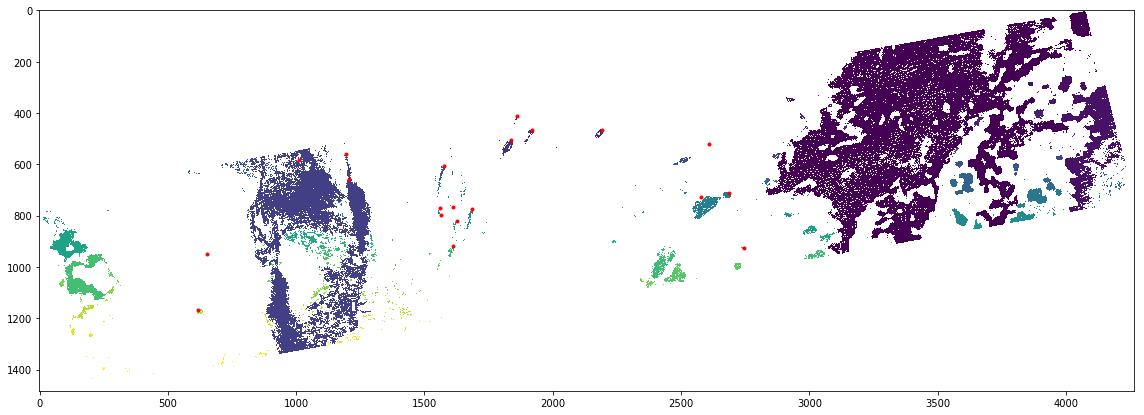

In [41]:
# Any image 
ratio = max_values[2] / aod_r  # todo still need to get this to work for each max value.
mask = ratio <=3

labelled_image, n_labels = label(mask, return_num=True)

# get rid of singleton labels
label_size = [(labelled_image == l).sum() for l in range(n_labels + 1)]
for l,s in enumerate(label_size):
    if s <= 5:
        mask[labelled_image == l] = 0
        labelled_image[labelled_image == l] = 0

im = np.ma.masked_array(labelled_image, labelled_image == 0)

plt.figure(figsize=(20,7))
plt.imshow(im)
plt.plot(new_x,new_y, 'r.')
plt.show()

Now find nearest label for each fire

In [42]:
# setup the distance matrix.  If no plume within
# five pixel radius then we consider no nearby 
# smoke plume.
window_size = 10
x = np.arange(-window_size, window_size+1)
y = np.arange(-window_size, window_size+1)
dx, dy = np.meshgrid(x, y)
distance_matrix = np.sqrt(dx**2 + dy**2)

# for each fire, get the nearest class
label_nearest_fire = []
for x, y in zip(new_x, new_y):
    labelled_image_subset = labelled_image[y-window_size:y+window_size+1, x-window_size:x+window_size+1]
    label_mask = labelled_image_subset != 0
    
    if label_mask.any():
        labelled_image_subset = labelled_image_subset[label_mask]
        distances = distance_matrix[label_mask]
        
        label_nearest_fire.append(labelled_image_subset[np.argmin(distances)])

print(label_nearest_fire)

# drop fires associated with repeated labels
final_fires_x = []
final_fires_y = []
final_labels = []
for x, y, l in zip(new_x, new_y, label_nearest_fire):
    appearences = np.sum(label_nearest_fire == l)
    if appearences < 2:
        final_fires_x.append(x)
        final_fires_y.append(y)
        final_labels.append(l)

[824, 2060, 901, 3220, 4303, 3218, 1966, 2615, 2475, 2320, 2246, 2303, 1339, 624, 737, 638, 1029, 901, 473]


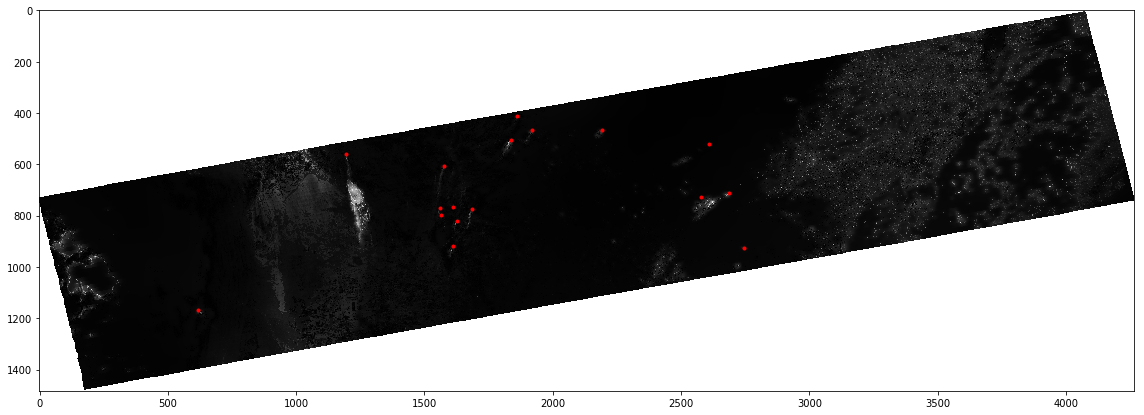

In [43]:
plt.figure(figsize=(20,7))
plt.imshow(aod_r, cmap='gray')
plt.plot(final_fires_x,final_fires_y, 'r.')
plt.show()

Now extract the plume for the defined label:

In [44]:
for l in np.unique(labelled_image):
    if l not in final_labels:
        labelled_image[labelled_image == l] = 0


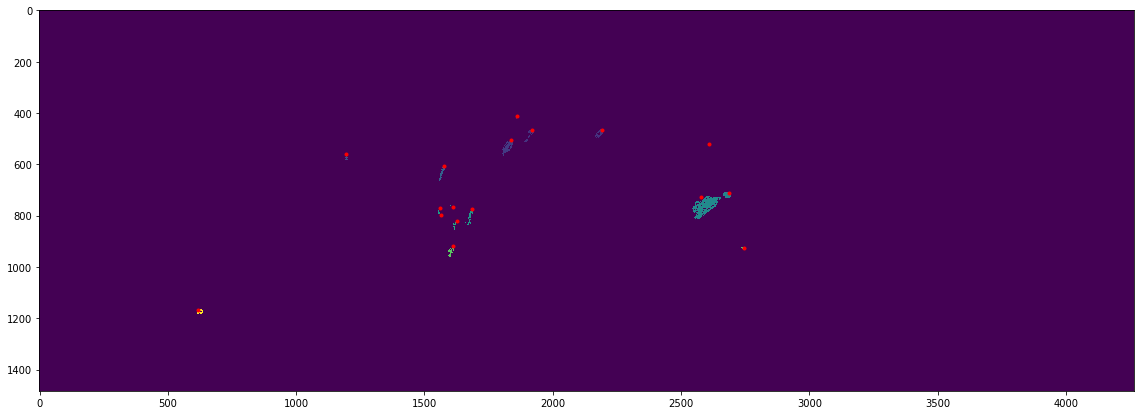

In [45]:
plt.figure(figsize=(20,7))
plt.imshow(labelled_image)
plt.plot(final_fires_x,final_fires_y, 'r.')
plt.show()

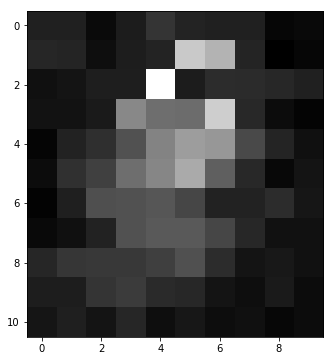

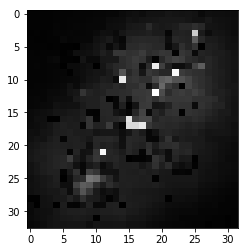

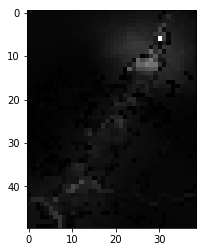

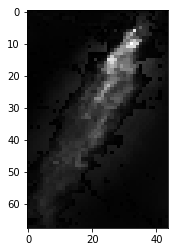

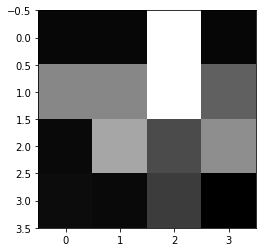

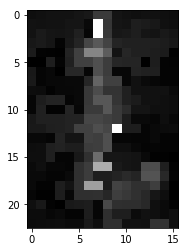

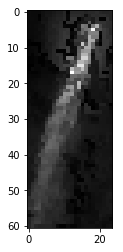

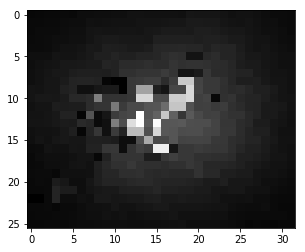

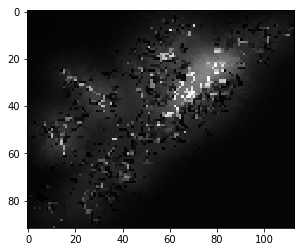

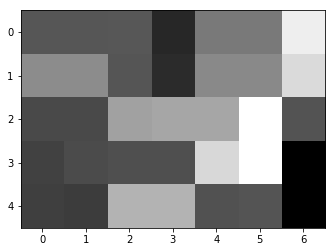

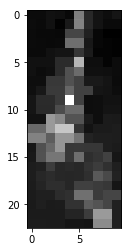

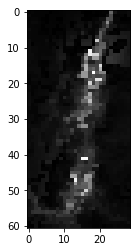

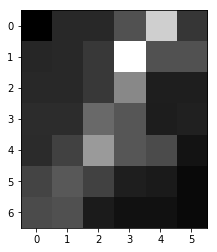

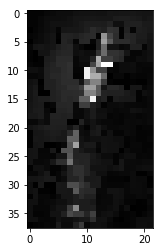

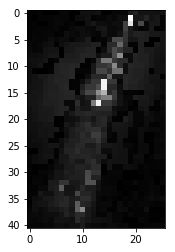

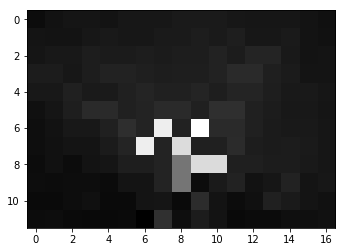

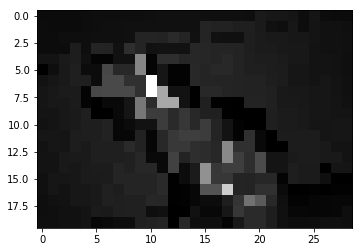

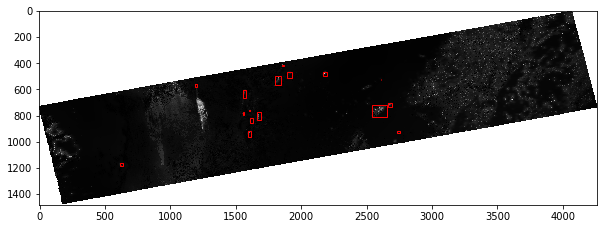

In [46]:
plt.close('all')
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(aod_r, cmap='gray')

for region in regionprops(labelled_image):
    minr, minc, maxr, maxc = region.bbox
    plt.imshow(aod_r[minr:maxr, minc:maxc], cmap='gray')
    plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(aod_r, cmap='gray')    

for region in regionprops(labelled_image):
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(rect)
plt.show()

Functions:

In [17]:
def extract_fires_for_roi(df, ts, extent):
    time_subset = df[df.date_time == ts]
    time_space_subset = time_subset[((df.latitude > extent['min_lat']) &
                                    (df.latitude < extent['max_lat']) &
                                    (df.longitude > extent['min_lon']) &
                                    (df.longitude < extent['max_lon']))]
    return time_space_subset

def create_resampler(viirs_data):
    lats = viirs_data['All_Data']['VIIRS-MOD-GEO_All']['Latitude'][:]
    lons = viirs_data['All_Data']['VIIRS-MOD-GEO_All']['Longitude'][:]
    return tools.utm_resampler(lats, lons, 750)


def read_aod_mask(arr, bit_pos, bit_len, value):
    '''Generates mask with given bit information.
    Parameters
        bit_pos		-	Position of the specific QA bits in the value string.
        bit_len		-	Length of the specific QA bits.
        value  		-	A value indicating the desired condition.
    '''
    bitlen = int('1' * bit_len, 2)

    if type(value) == str:
        value = int(value, 2)

    pos_value = bitlen << bit_pos
    con_value = value << bit_pos
    mask = (arr & pos_value) == con_value
    return mask


def make_balltree_subset(array_lats_flat, array_lons_flat):
    array_lat_lon = np.dstack([np.deg2rad(array_lats_flat), np.deg2rad(array_lons_flat)])[0]
    return BallTree(array_lat_lon, metric='haversine')


def spatial_intersection_subset(array_balltree, point_lats, point_lons, x_positions_flat, y_positions_flat):
    # get the unique flare lats and lons for assessment in kdtree
    point_location = np.dstack((np.deg2rad(point_lats), np.deg2rad(point_lons))).squeeze()

    # compare the flare locations to the potential locations in the orbit
    distance, index = array_balltree.query(point_location, k=1)

    # get indexes
    x = x_positions_flat[index]
    y = y_positions_flat[index]
    d = distance

    return x, y, np.rad2deg(d)